<a href="https://colab.research.google.com/github/auspicious0/Loan_SVM/blob/main/Loan_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#패키지 부착 및 출력 그래프의 크기 설정
install.packages(c("tidyverse", "caret", "e1071", "Hmisc"))
library(tidyverse)
library(data.table)

library(repr)
options(repr.plot.width = 7, repr.plot.height = 7)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘checkmate’, ‘htmlwidgets’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘proxy’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [46]:
#https://www.kaggle.com/datasets/sarahvch/predicting-who-pays-back-loans?select=loan_data.csv
#https://drive.google.com/file/d/1SfB1iLRv7wyKsZLMxT-2rGwPnROv0BDl/view?usp=sharing
system("gdown --id 1SfB1iLRv7wyKsZLMxT-2rGwPnROv0BDl")
system("ls",TRUE)

[1] "loan_data.csv" "sample_data"

파일이 잘 읽혔습니다.데이터를 읽고 데이터 변수의 특징에 따라 전처리를 수행하겠습니다.

In [53]:
lo <- fread("loan_data.csv",encoding = "UTF-8") %>% as_tibble()
lo %>% show()
str(lo)
summary(lo)


# A tibble: 9,578 × 14
   credit.policy purpose         int.rate installment log.annual.inc   dti  fico
           <int> <chr>              <dbl>       <dbl>          <dbl> <dbl> <int>
 1             1 debt_consolida…   0.119        829.            11.4  19.5   737
 2             1 credit_card       0.107        228.            11.1  14.3   707
 3             1 debt_consolida…   0.136        367.            10.4  11.6   682
 4             1 debt_consolida…   0.101        162.            11.4   8.1   712
 5             1 credit_card       0.143        103.            11.3  15.0   667
 6             1 credit_card       0.0788       125.            11.9  17.0   727
 7             1 debt_consolida…   0.150        194.            10.7   4     667
 8             1 all_other         0.111        131.            11.0  11.1   722
 9             1 home_improveme…   0.113         87.2           11.4  17.2   682
10             1 debt_consolida…   0.122         84.1           10.2  10     707
# ℹ 9

 credit.policy     purpose             int.rate       installment    
 Min.   :0.000   Length:9578        Min.   :0.0600   Min.   : 15.67  
 1st Qu.:1.000   Class :character   1st Qu.:0.1039   1st Qu.:163.77  
 Median :1.000   Mode  :character   Median :0.1221   Median :268.95  
 Mean   :0.805                      Mean   :0.1226   Mean   :319.09  
 3rd Qu.:1.000                      3rd Qu.:0.1407   3rd Qu.:432.76  
 Max.   :1.000                      Max.   :0.2164   Max.   :940.14  
 log.annual.inc        dti              fico       days.with.cr.line
 Min.   : 7.548   Min.   : 0.000   Min.   :612.0   Min.   :  179    
 1st Qu.:10.558   1st Qu.: 7.213   1st Qu.:682.0   1st Qu.: 2820    
 Median :10.929   Median :12.665   Median :707.0   Median : 4140    
 Mean   :10.932   Mean   :12.607   Mean   :710.8   Mean   : 4561    
 3rd Qu.:11.291   3rd Qu.:17.950   3rd Qu.:737.0   3rd Qu.: 5730    
 Max.   :14.528   Max.   :29.960   Max.   :827.0   Max.   :17640    
   revol.bal         revol.

결측값은 없습니다.

우선 정수형 변수들 중 min 값이 0, max값이 5이하인 변수들을 unique()를 통해 factor형으로 변환이 가능한 변수인지 알아보겠습니다.

문자형 변수(purpose)와 not.fully.faid(반응, 종속변수) 역시 factor형으로 변환 가능한 변수인지 살피겠습니다.

In [54]:
lo$credit.policy %>% unique()
lo$purpose %>% unique()
lo$pub.rec %>% unique()
lo$not.fully.paid %>% unique()

[1] 1 0

[1] "debt_consolidation" "credit_card"        "all_other"         
[4] "home_improvement"   "small_business"     "major_purchase"    
[7] "educational"

[1] 0 1 2 3 4 5

[1] 0 1

위 네개의 변수 (credit.policy, purpose, pub.rec, not.fully.paid)는 factor형으로 변환하겠습니다.

또한 결측값은 앞서 살펴본 대로 결측값은 없기 때문에 이상값 처리를 진행하겠습니다.

In [55]:
lo <- lo %>%
  mutate_at(c("credit.policy", "purpose", "pub.rec", "not.fully.paid"),factor)
lo %>% str()

tibble [9,578 × 14] (S3: tbl_df/tbl/data.frame)
 $ credit.policy    : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ purpose          : Factor w/ 7 levels "all_other","credit_card",..: 3 2 3 3 2 2 3 1 5 3 ...
 $ int.rate         : num [1:9578] 0.119 0.107 0.136 0.101 0.143 ...
 $ installment      : num [1:9578] 829 228 367 162 103 ...
 $ log.annual.inc   : num [1:9578] 11.4 11.1 10.4 11.4 11.3 ...
 $ dti              : num [1:9578] 19.5 14.3 11.6 8.1 15 ...
 $ fico             : int [1:9578] 737 707 682 712 667 727 667 722 682 707 ...
 $ days.with.cr.line: num [1:9578] 5640 2760 4710 2700 4066 ...
 $ revol.bal        : int [1:9578] 28854 33623 3511 33667 4740 50807 3839 24220 69909 5630 ...
 $ revol.util       : num [1:9578] 52.1 76.7 25.6 73.2 39.5 51 76.8 68.6 51.1 23 ...
 $ inq.last.6mths   : int [1:9578] 0 0 1 1 0 0 0 0 1 1 ...
 $ delinq.2yrs      : int [1:9578] 0 0 0 0 1 0 0 0 0 0 ...
 $ pub.rec          : Factor w/ 6 levels "0","1","2","3",..: 1 1 1 1 1 1 2 1 1 1 ...
 $ n


 FALSE 
134092 


 FALSE   TRUE 
130837   3255 


FALSE 
96040 

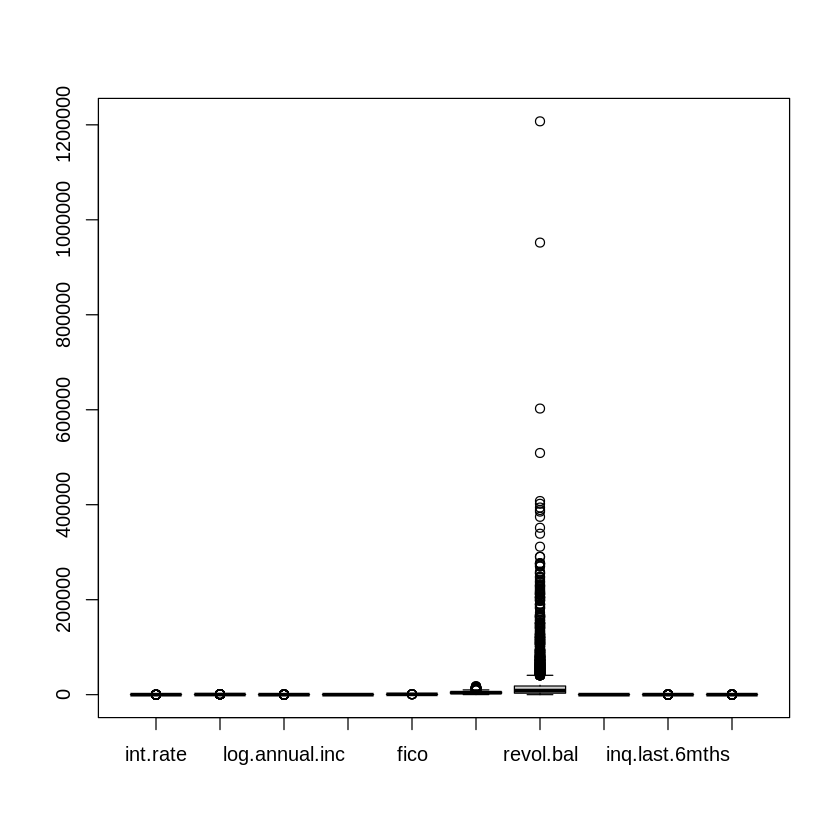

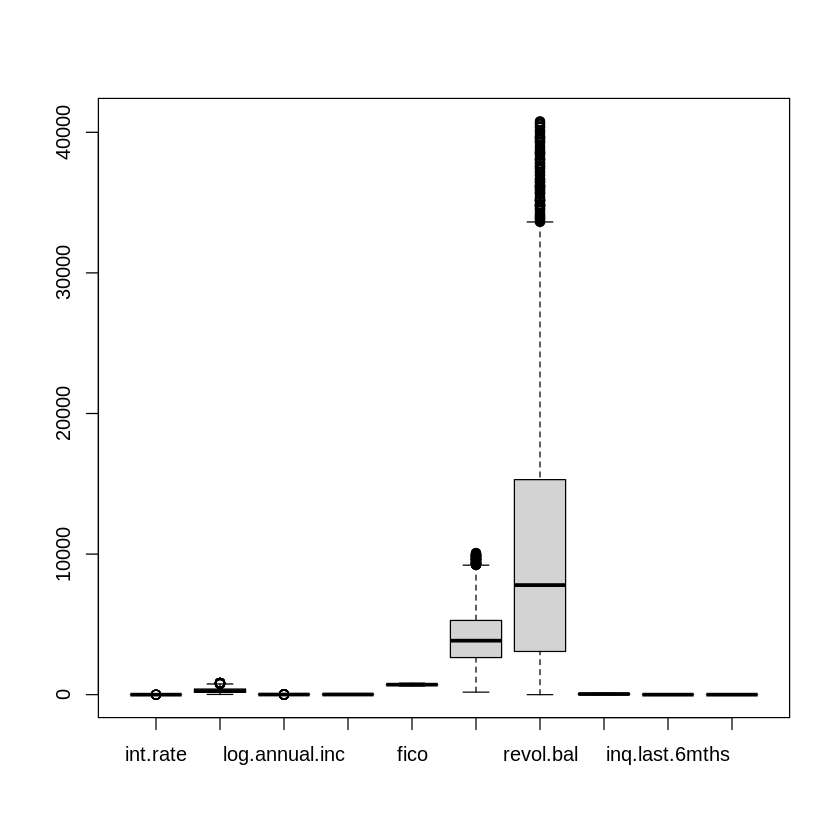

In [56]:
# 이상치 및 결측값 처리 함수

calculate_outliers <- function(data, column_name) {
  iqr_value <- IQR(data[[column_name]])
  upper_limit <- summary(data[[column_name]])[5] + 1.5 * iqr_value
  lower_limit <- summary(data[[column_name]])[2] - 1.5 * iqr_value

  data[[column_name]] <- ifelse(data[[column_name]] < lower_limit | data[[column_name]] > upper_limit, NA, data[[column_name]])

  return(data)
}
table(is.na(lo))
# boxplot 을 그리기 위해 factor형 변수를 삭제해 lo_에 저장하겠습니다.
lo_ <- lo %>% select(-credit.policy, -purpose, -pub.rec, -not.fully.paid)
boxplot(lo_)
# 이상치 및 결측값 처리 및 결과에 대한 상자그림 그리기
lo <- calculate_outliers(lo, "int.rate")
lo <- calculate_outliers(lo, "installment")
lo <- calculate_outliers(lo, "log.annual.inc")
lo <- calculate_outliers(lo, "dti")
lo <- calculate_outliers(lo, "fico")
lo <- calculate_outliers(lo, "days.with.cr.line")
lo <- calculate_outliers(lo, "revol.bal")
lo <- calculate_outliers(lo, "revol.util")
lo <- calculate_outliers(lo, "inq.last.6mths")
lo <- calculate_outliers(lo, "delinq.2yrs")

table(is.na(lo))
lo <- na.omit(lo)
table(is.na(lo))
lo_ <- lo %>% select(-credit.policy, -purpose, -pub.rec, -not.fully.paid)
boxplot(lo_)


이상값 처리를 완료하였습니다.

무작위로 데이터를 분리하지 않고 반응변수를 중심으로 8:2로 나누기 위해 caret::createDataPartition을 사용하겠습니다.

In [59]:
library(caret)
index <- caret::createDataPartition(y = lo$not.fully.paid, p = 0.8, list = FALSE)
train <- lo[index,]
test <- lo[-index,]

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [60]:
train %>% show()
test%>% show()

# A tibble: 5,489 × 14
   credit.policy purpose         int.rate installment log.annual.inc   dti  fico
   <fct>         <fct>              <dbl>       <dbl>          <dbl> <dbl> <int>
 1 1             debt_consolida…   0.119        829.           11.4  19.5    737
 2 1             credit_card       0.107        228.           11.1  14.3    707
 3 1             debt_consolida…   0.136        367.           10.4  11.6    682
 4 1             debt_consolida…   0.101        162.           11.4   8.1    712
 5 1             debt_consolida…   0.150        194.           10.7   4      667
 6 1             all_other         0.111        131.           11.0  11.1    722
 7 1             debt_consolida…   0.122         84.1          10.2  10      707
 8 1             debt_consolida…   0.135        360.           10.4  22.1    677
 9 1             debt_consolida…   0.0863       210.            9.49  9.73   727
10 1             major_purchase    0.110        328.           10.7  13.0    702
# ℹ 5

데이터가 잘 분할 되었습니다.

In [ ]:
#test 데이터는